In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import ElasticNet
# from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from utils_data_structures import col_prefixes

In [2]:
grouped_df = pd.read_csv('sorare_data/large_grouped_sorare_data.csv')

grouped_df = grouped_df.fillna(0.0)
# grouped_df = pd.get_dummies(grouped_df, columns=['Current_Club'])
# grouped_df = grouped_df.drop(columns=['Current_Club'])

print(grouped_df['So_5_Scores_9'].isna().sum())

0


In [3]:
epl_forwards_df = grouped_df[grouped_df['Position'] == 'Forward']
epl_forwards_df = epl_forwards_df.drop(columns=['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club'])

In [4]:
epl_forwards_df.dtypes.value_counts()

float64    309
int64        4
Name: count, dtype: int64

In [5]:
# Create X and y and split into training and testing sets
target_column = 'So_5_Scores_9'
columns_to_drop = [f'{col}_9' for col in col_prefixes]

X = epl_forwards_df.drop(columns=columns_to_drop)
y = epl_forwards_df[target_column]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
y_pred_xgb_clipped = np.clip(y_pred_xgb, 0, 100)
mse = mean_squared_error(y_test, y_pred_xgb_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 17.031600147402553


In [8]:
# Initialize the LightGBM regressor
lgbm_model = lgb.LGBMRegressor(
    boosting_type='gbdt',  # Gradient boosting decision tree
    n_estimators=400,      # Number of boosting rounds (trees)
    learning_rate=0.01,     # Step size shrinkage
    max_depth=10,          # Unlimited depth of trees (-1 means no limit)
    random_state=42,        # For reproducibility
)

# Train the model
lgbm_model.fit(X_train, y_train)
# Make predictions
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluate
y_pred_lgmb_clipped = np.clip(y_pred_lgbm, 0, 100)
mse = mean_squared_error(y_test, y_pred_lgmb_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7915
[LightGBM] [Info] Number of data points in the train set: 2965, number of used features: 192
[LightGBM] [Info] Start training from score 18.712180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
RMSE: 16.435894048371516


In [9]:

# Initialize ElasticNet
elastic_model = ElasticNet(alpha=0.05, l1_ratio=0.9, random_state=42)

# Train the model
elastic_model.fit(X_train, y_train)

# Make predictions
y_pred_en = elastic_model.predict(X_test)

# Evaluate
y_pred_en_clipped = np.clip(y_pred_en, 0, 100)
mse = mean_squared_error(y_test, y_pred_en_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 16.715620407313857


c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.504e+05, tolerance: 1.784e+02
  model = cd_fast.enet_coordinate_descent(


In [10]:
with open('sorare_models/forwards_xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)
    print("XGB Model saved successfully!")
with open('sorare_models/forwards_lgbm_model.pkl', 'wb') as file:
    pickle.dump(lgbm_model, file)
    print("LGBM Model saved successfully!")

with open('sorare_models/forwards_elastic_model.pkl', 'wb') as file:
    pickle.dump(elastic_model, file)
    print("Elastic Model saved successfully!")

print("Models saved successfully!")

XGB Model saved successfully!
LGBM Model saved successfully!
Elastic Model saved successfully!
Models saved successfully!


In [11]:
y_test_df = pd.DataFrame(y_test)
y_test_df['XBG_Predictions'] = y_pred_xgb_clipped
y_test_df['LGBM_Predictions'] = y_pred_lgmb_clipped
y_test_df['EN_Predictions'] = y_pred_en_clipped
y_test_df

,So_5_Scores_9,XBG_Predictions,LGBM_Predictions,EN_Predictions
13076,37.1,37.956734,38.898820,31.724397
4267,64.5,14.832029,24.882507,21.153009
8335,32.6,34.826740,32.960483,26.142938
3163,32.3,32.640137,35.624570,37.823247
3217,43.3,44.974094,38.693153,41.601183
...,...,...,...,...
7888,0.0,1.289248,1.443905,0.583826
2382,44.6,40.738682,43.322642,44.334005
6814,0.0,20.549337,21.804156,19.771350
6760,0.0,0.011324,1.263409,1.448683


In [12]:
y_test_df['Average_Prediction'] = (y_test_df['XBG_Predictions'] + y_test_df['LGBM_Predictions'] + y_test_df['EN_Predictions']) / 3
y_test_df

,So_5_Scores_9,XBG_Predictions,LGBM_Predictions,EN_Predictions,Average_Prediction
13076,37.1,37.956734,38.898820,31.724397,36.193317
4267,64.5,14.832029,24.882507,21.153009,20.289182
8335,32.6,34.826740,32.960483,26.142938,31.310054
3163,32.3,32.640137,35.624570,37.823247,35.362651
3217,43.3,44.974094,38.693153,41.601183,41.756144
...,...,...,...,...,...
7888,0.0,1.289248,1.443905,0.583826,1.105660
2382,44.6,40.738682,43.322642,44.334005,42.798443
6814,0.0,20.549337,21.804156,19.771350,20.708281
6760,0.0,0.011324,1.263409,1.448683,0.907806


In [13]:
y_true = y_test_df['So_5_Scores_9'].to_numpy()
y_pred = y_test_df['Average_Prediction'].to_numpy()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
rmse

16.39585608836834

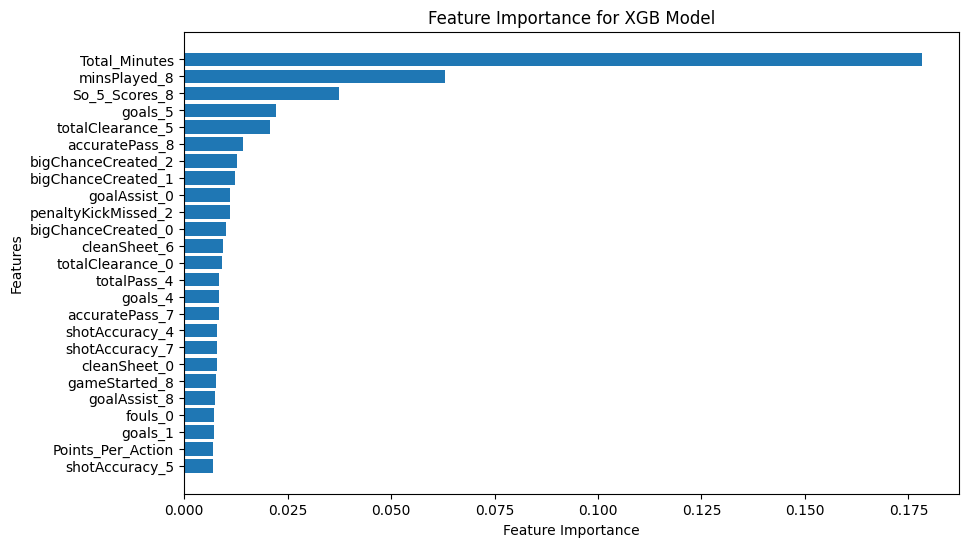

In [14]:

# Get feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

top_n = 25  # Number of top features to show
top_features = feature_importance_df.nlargest(top_n, 'Importance')

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for XGB Model')
plt.gca().invert_yaxis()
plt.show()

In [15]:
epl_teams = pd.read_csv('sorare_data/large_cleaned_sorare_data.csv')

epl_teams = epl_teams.fillna(0.0)

epl_forwards_df = epl_teams[epl_teams['Position'] == 'Forward']

epl_forwards_df = epl_forwards_df.reset_index(drop=True)

In [16]:
drop_columns = columns=['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club']

columns_to_drop = [f'{col}_9' for col in col_prefixes]
columns_to_drop.extend(drop_columns)

target_column = 'So_5_Scores_9'

X_test_forwards = epl_forwards_df.drop(columns=columns_to_drop)
y_test_forwards = epl_forwards_df[target_column]

In [17]:
with open('sorare_models/forwards_xgb_model.pkl', 'rb') as file:
    forwards_xgb_model_loaded = pickle.load(file)
    print("XGB Model loaded successfully!")
with open('sorare_models/forwards_lgbm_model.pkl', 'rb') as file:
    forwards_lgbm_model_loaded = pickle.load(file)
    print("LGBM Model loaded successfully!")
with open('sorare_models/forwards_elastic_model.pkl', 'rb') as file:
    forwards_elastic_model_loaded = pickle.load(file)
    print("Elastic Model loaded successfully!")

XGB Model loaded successfully!
LGBM Model loaded successfully!
Elastic Model loaded successfully!


In [18]:
xgb_predictions = forwards_xgb_model_loaded.predict(X_test_forwards)
lgbm_predictions = forwards_lgbm_model_loaded.predict(X_test_forwards)
elastic_predictions = forwards_elastic_model_loaded.predict(X_test_forwards)

xgb_predictions = np.clip(xgb_predictions, 0, 100)
lgbm_predictions = np.clip(lgbm_predictions, 0, 100)
elastic_predictions = np.clip(elastic_predictions, 0, 100)

y_test_forwards_df = pd.DataFrame(y_test_forwards)

epl_forwards_df['xgb_predictions'] = pd.Series(xgb_predictions)
epl_forwards_df['lgbm_predictions'] = pd.Series(lgbm_predictions)
epl_forwards_df['elastic_predictions'] = pd.Series(elastic_predictions)

epl_forwards_df['Average_Prediction'] = epl_forwards_df[['xgb_predictions', 'lgbm_predictions', 'elastic_predictions']].mean(axis=1)

epl_forwards_df[['So_5_Scores_9','xgb_predictions', 'lgbm_predictions', 'elastic_predictions']].head(3)

,So_5_Scores_9,xgb_predictions,lgbm_predictions,elastic_predictions
0,47.100000,46.405117,48.049277,41.320080
1,33.423575,33.386581,33.026150,29.883625
2,0.000000,0.032436,12.440056,18.348078


In [19]:
y_true = epl_forwards_df['So_5_Scores_9'].to_numpy()
y_pred = epl_forwards_df['Average_Prediction'].to_numpy()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
rmse

13.925413825419009

In [20]:
saved_forwards_df = epl_forwards_df[['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club','So_5_Scores_9','xgb_predictions', 'lgbm_predictions', 'elastic_predictions']]
saved_forwards_df.to_csv('sorare_data/predictions/sorare_forwards_predictions.csv', index=False)